# 3. How do we Assemble Genomes?


---



Determining the order of nucleotides in a genome, or **genome sequencing**, presents a fundamental task in bioinformatics. Biologists still lack the technology to read the nucleotides of a genome from beginning to end. Instead, they sequence much shorter DNA fragments called **reads**.

Researchers take a small tissue or blood sample containing millions of cells with identical DNA, use biochemical methods to break the DNA into fragments, and then sequence these fragments to produce reads. The difficulty is that researchers do not know where in the genome these reads came from, and so they must use overlapping reads
to reconstruct the genome.

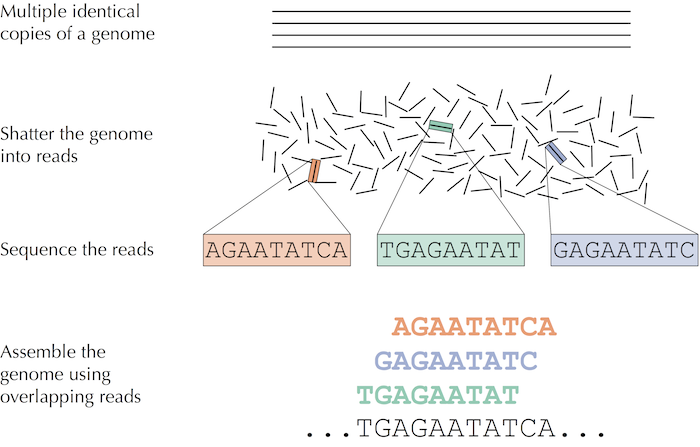

# The String Reconstruction Problem

There are a few practical complications that make genome assembly difficult.

First, DNA is double-stranded, and we have no way of knowing *a priori* which strand a given read derives from, meaning that we will not know whether to use a read or its reverse complement when assembling a particular strand of a genome.

Second, modern sequencing machines are not perfect, and the reads that they generate often contain errors. Sequencing errors complicate genome assembly because they prevent us from identifying all overlapping reads.

Third, some regions of the genome may not be covered by any reads, making it impossible to reconstruct the entire genome.

Since the reads generated by modern sequencers often have the same length, we may safely assume that reads are all $k$-mers for some value of $k$. For now, we will assume that all reads come from the same strand, have no errors, and exhibit perfect coverage, so that every $k$-mer substring of the genome is generated as a read.

Given a string $\text{Text}$, its **$k$-mer composition** $\text{Composition}_k(\text{Text})$ is the collection of all $k$-mer substrings of $\text{Text}$ (including repeated $k$-mers), arranged in **lexicographic order** (i.e., how they would appear
in a dictionary). Finding the $k$-mer composition of a string is called the **String Composition Problem**.

In [ ]:
def composition(text, k):

  k_mers = [text[i:i+k] for i in range(len(text)-k+1)]
  k_mers.sort()

  return k_mers

In [ ]:
composition("TATGGGGTGC",3)

['ATG', 'GGG', 'GGG', 'GGT', 'GTG', 'TAT', 'TGC', 'TGG']

In order to model genome assembly, we need to solve the inverse of the String Composition Problem. That is, we need to reconstruct a string from its $k$-mer composition - the **String Reconstruction Problem**.

The most natural way to solve the String Reconstruction Problem is to “connect” a pair of $k$-mers if they overlap in $k - 1$ symbols. Consider the composition `AAT ATG GTT TAA TGT`. As no $3$-mer ends with `TA`, the string must start with `TAA`. This has to be followed by `AAT`, `ATG`, `TGT` and `GTT`. Thus, the reconstructed string is `TAATGTT`.

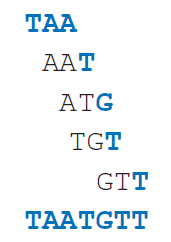

However, this becomes difficult when a $k$-mer repeats many times. For such a repeat, there will be many choices for the next "connection" while reconstructing the string.

Consider the composition `AAT ATG ATG ATG CAT CCA GAT GCC GGA GGG GTT TAA TGC TGG TGT`. The $3$-mer `ATG` occurs thrice and can be connected to `TGC`, `TGG` or `TGT`. Making a single incorrect choice can lead to an incorrectly reconstructed string.

This is a problem as approximately 50% of the human genome is made up of repeats, e.g., the approximately 300 nucleotide-long **Alu sequence** is repeated over a million times, with only a few nucleotides inserted/deleted/substituted each time.

# String Reconstruction as a Walk in the Overlap Graph

Repeats in a genome necessitate some way of looking ahead to see the correct assembly in advance. Returning to the previous example, it can be found that `TAATGCCATGGGATGTT` is a solution to the String Reconstruction Problem. Note that a different color is used for each interval of the string between occurrences of `ATG` in the illustration below.

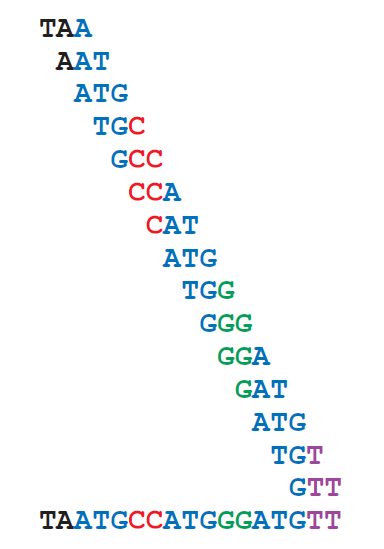

Consecutive $3$-mers in `TAATGCCATGGGATGTT` can be linked together to form a **genome path**.

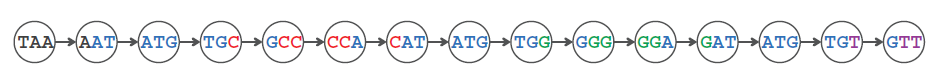

Obviously, it is possible to reconstruct a genome if its genome path is known. Unfortunately, constructing the genome path requires us to know the genome in advance. We only know the $k$-mer composition of the genome.

In [ ]:
def genome_from_genome_path(patterns):

  genome = patterns[0]

  for pattern in patterns[1:]:
    genome += pattern[-1]

  return genome

In [ ]:
genome_from_genome_path(['TAA','AAT','ATG','TGC','GCC','CCA','CAT','ATG','TGG','GGG','GGA','GAT','ATG','TGT','GTT'])

'TAATGCCATGGGATGTT'

We use the terms **prefix** and **suffix** to refer to the first $k - 1$ nucleotides and last $k - 1$ nucleotides of a $k$-mer, respectively. For example, $\text{Prefix}$(`TAA`) = `TA` and $\text{Suffix}$(`TAA`) = `AA`. We note that the suffix of a $k$-mer in the genome path is equal to the prefix of the following $k$-mer in the path.

This observation suggests a method of constructing a string's genome path from its $k$-mer composition: we will use an arrow to connect any $k$-mer $\text{Pattern}$ to another $k$-mer $\text{Pattern}'$ if the suffix of $\text{Pattern}$ is equal to the prefix of $\text{Pattern}'$.

Because we don't know the genome in advance, we will wind up connecting pairs of $3$-mers that are not consecutive in the actual genome path. For the earlier example, these connections will look like:

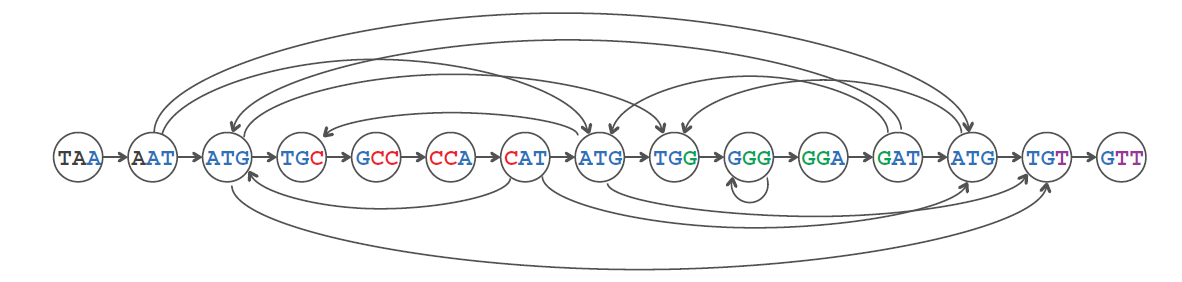

This is an example of a **graph**, or a network of **nodes** connected by
**edges**. This particular graph is an example of a **directed graph**, whose edges have a direction and are represented by arrows (as opposed to **undirected graphs** whose edges do not have directions).

In the above graph, the genome path is still visible as we already know the correct order of $k$-mers. However, a $k$-mer composition is in lexicographic order. When we consider this, we produce the **overlap graph** of the genome, and the genome path seemingly vanishes!

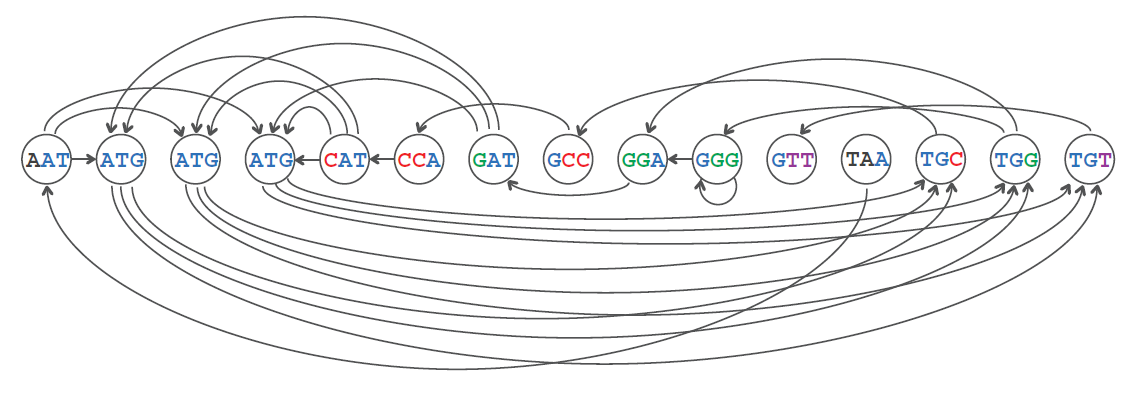

When we are representing a graph computationally, the only information we need to store is the pair of nodes that each edge connects. There are two standard ways of representing a graph.

For a directed graph with $n$ nodes, the $n \times n$ **adjacency matrix** $(A_{i,j})$ is defined by the following rule: $A_{i,j} = 1$ if a directed edge connects node $i$ to node $j$, and $A_{i,j} = 0$ otherwise.

Another (more memory-efficient) way of representing a graph is to use an **adjacency list**, for which we simply list all nodes connected to each node.

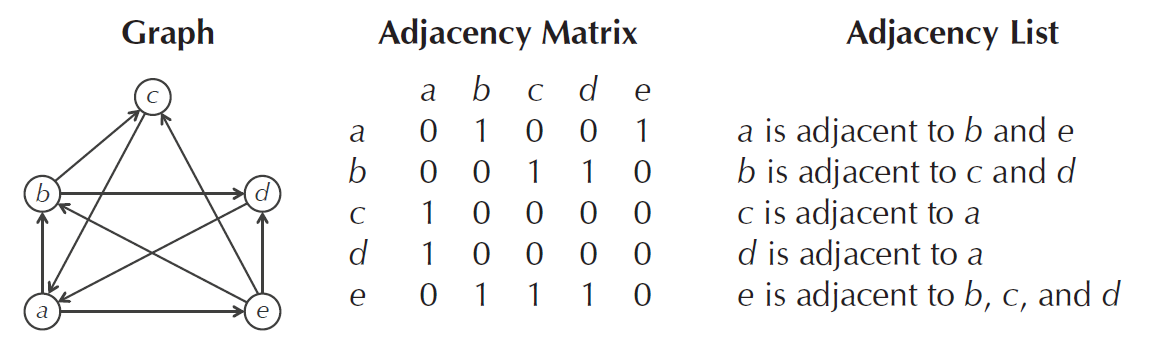

The first step in genome reconstruction would be to form the overlap graph from the $k$-mer composition.

In [ ]:
def construct_overlap_graph(patterns):

  patterns.sort()

  overlap_graph = []
  for pattern1 in patterns:
    suffix = pattern1[1:]
    for pattern2 in patterns:
      prefix = pattern2[:-1]
      if suffix == prefix:
        overlap_graph.append((pattern1,pattern2))

  return overlap_graph

In [ ]:
for pattern1, pattern2 in construct_overlap_graph(composition("TAATGGGATGCCATGTT",3)):
  print(f"{pattern1} -> {pattern2}")

AAT -> ATG
AAT -> ATG
AAT -> ATG
ATG -> TGC
ATG -> TGG
ATG -> TGT
ATG -> TGC
ATG -> TGG
ATG -> TGT
ATG -> TGC
ATG -> TGG
ATG -> TGT
CAT -> ATG
CAT -> ATG
CAT -> ATG
CCA -> CAT
GAT -> ATG
GAT -> ATG
GAT -> ATG
GCC -> CCA
GGA -> GAT
GGG -> GGA
GGG -> GGG
TAA -> AAT
TGC -> GCC
TGG -> GGA
TGG -> GGG
TGT -> GTT


Given the overlap graph, we would have to find a path through the graph visiting each node exactly once in order to assemble the genome. Such a path is called a **Hamiltonian path**. A graph may have more than one Hamiltonian path. Finding such a path in a directed graph is called the **Hamiltonian Path Problem**.

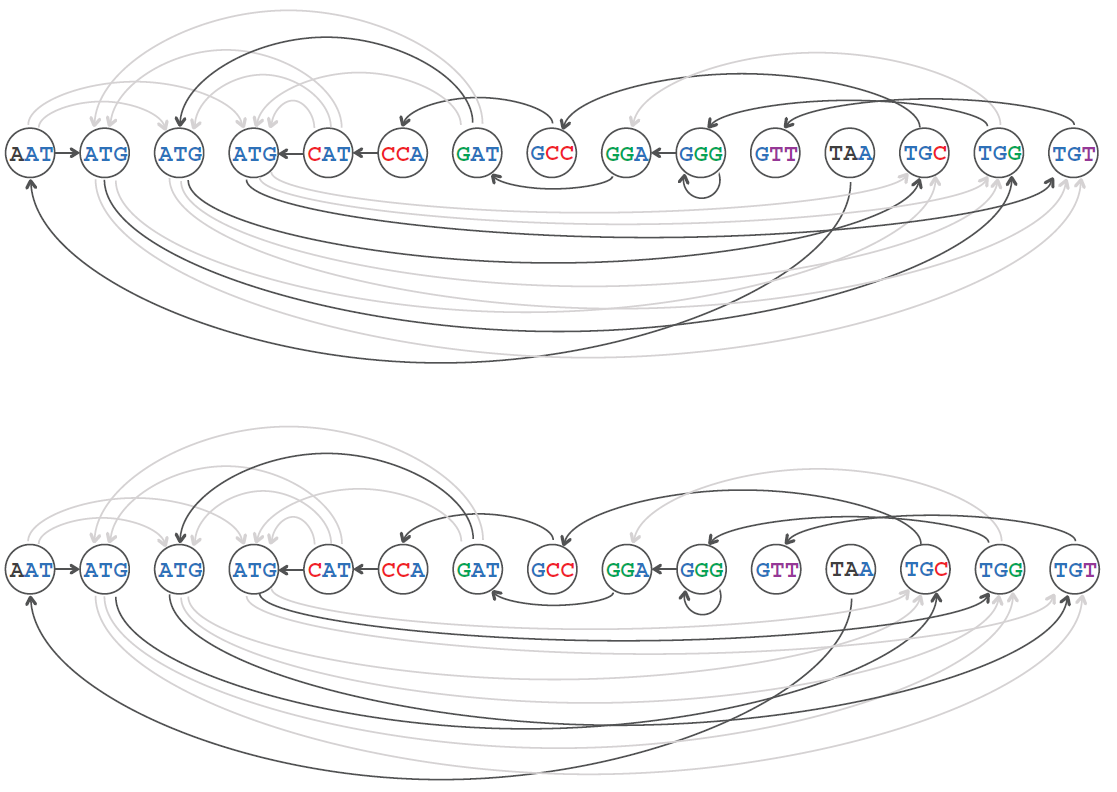

The figure on the top shows the genome path spelling out `TAATGCCATGGGATGTT`. The figure on the bottom shows another Hamiltonian path in the overlap graph that spells the genome `TAATGGGATGCCATGTT`. These two genomes differ by exchanging the positions of `CC` and `GG` but have the same $3$-mer composition.

We will not attempt to solve the Hamiltonian Path Problem at the given moment as it is not yet clear how we can design an efficient algorithm for it. Instead, we will look at a different problem.

A **binary string** is a string composed only of $0$'s and $1$'s. A binary string is **$k$-universal** if it contains every binary $k$-mer exactly once. For example, $0001110100$ is a $3$-universal string, as it contains each of the eight binary $3$-mers ($000, 001, 011, 111, 110, 101, 010,$ and $100$) exactly once.

Finding a $k$-universal string is equivalent to solving the String Reconstruction Problem when the $k$-mer composition is the collection of all binary $k$-mers. Thus, finding a $k$-universal string is equivalent to finding a Hamiltonian path in the overlap graph formed on all binary $k$-mers.

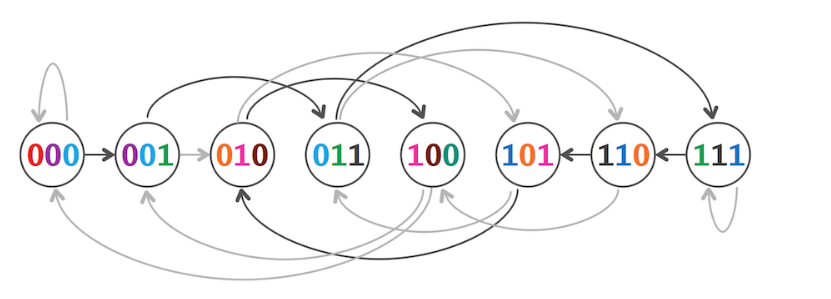

This method can be quite difficult for large values of $k$. Instead of searching for Hamiltonian paths in large graphs, the Dutch mathematician **Nicolaas de Bruijn** developed a completely different way of representing a $k$-mer composition using a graph.

# Another Graph for String Reconstruction

Instead of representing the genome as a sequence of its $k$-mers by assigning them to nodes, we assign them to the edges. Since each pair of consecutive edges represent consecutive $k$-mers that overlap in $k-1$ nucleotides, we label each node of this new graph with a $(k-1)$-mer representing the overlapping nucleotides shared by the edges on either side of the node. We call this the **path graph** of the genome.

For example, consider the $3$-mer path graph of the genome `TAATGCCATGGGATGTT`:

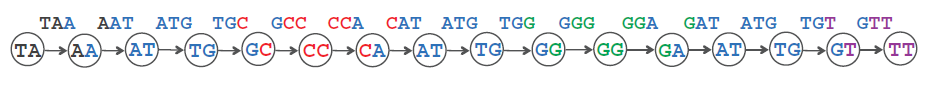

Next, we start **gluing** identically labeled nodes. We can bring the three `AT` nodes closer and closer to each other until they have been glued into a single node.

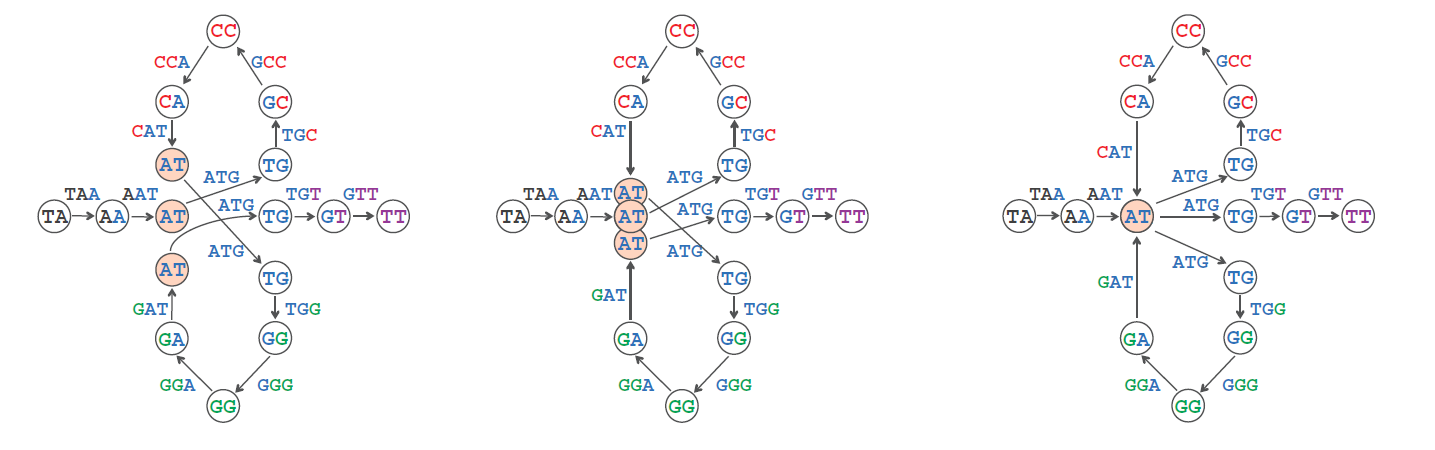

There are also three nodes labeled by `TG` which we can glue together.

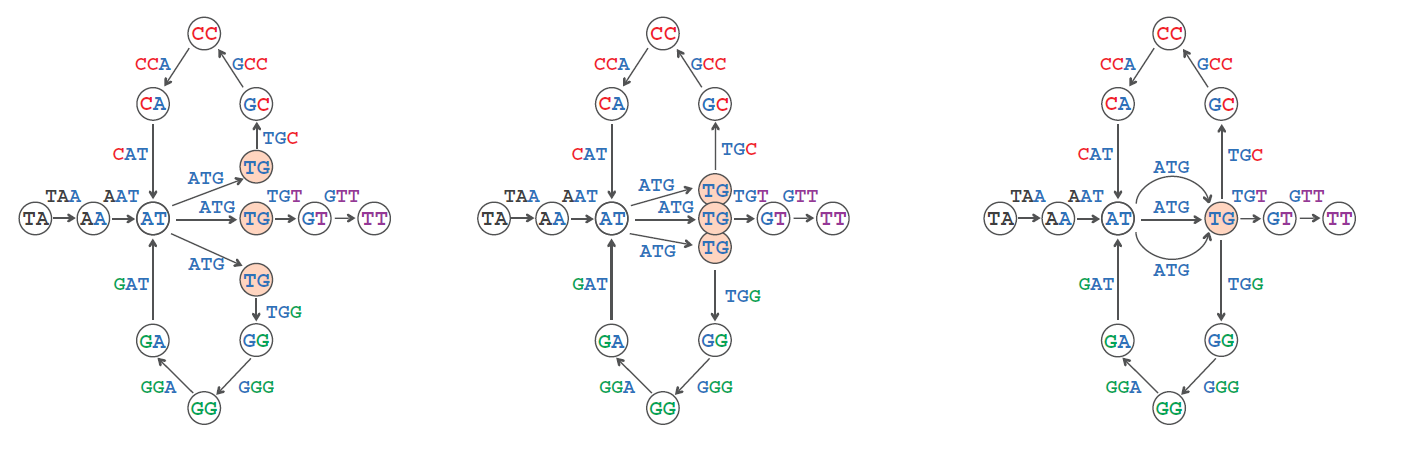

Finally, we glue together the two nodes labeled `GG` which produces a special type of edge called a **loop** connecting `GG` to itself.

The number of nodes in the resulting graph has reduced from 16 to 11, while the number of edges stayed the same. This graph is called the **de
Bruijn graph** of `TAATGCCATGGGATGTT`, denoted $\text{DeBruijn}_3$.

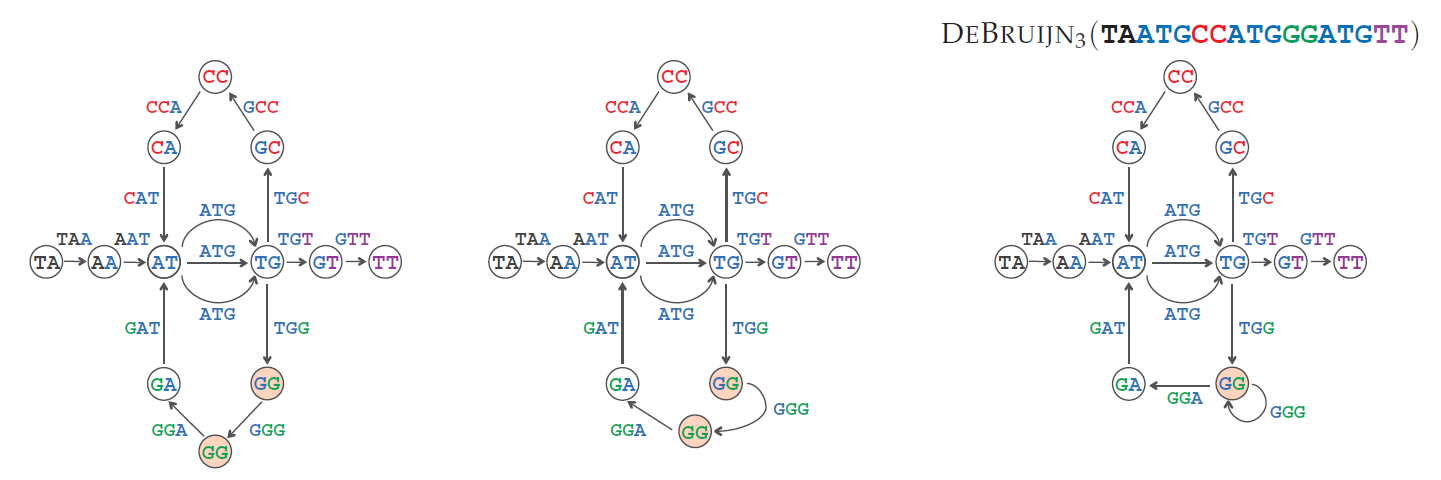

In [ ]:
def de_bruijn_from_genome(genome, k):

  de_bruijn = {}

  for i in range(len(genome)-k+1):
    current_node = genome[i:i+k-1]
    adjacent_node = genome[i+1:i+k]

    if current_node not in list(de_bruijn.keys()):
      de_bruijn[current_node] = [adjacent_node]
    else:
      de_bruijn[current_node].append(adjacent_node)

  return de_bruijn

In [ ]:
de_bruijn_from_genome("TAATGCCATGGGATGTT",3)

{'TA': ['AA'],
 'AA': ['AT'],
 'AT': ['TG', 'TG', 'TG'],
 'TG': ['GC', 'GG', 'GT'],
 'GC': ['CC'],
 'CC': ['CA'],
 'CA': ['AT'],
 'GG': ['GG', 'GA'],
 'GA': ['AT'],
 'GT': ['TT']}

# Walking in the de Bruijn Graph

Even though we have glued together nodes to form the de Bruijn graph, we have not changed its edges, and so the path from `TA` to `TT` reconstructing the genome is still hidden. Therefore, solving the String Reconstruction Problem reduces to finding a path in the de Bruijn graph that visits every edge exactly once. Such a path is called an **Eulerian path**.

For $\text{DeBruijn}_3$(`TAATGCCATGGGATGTT`), the Eulerian path is numbered below:

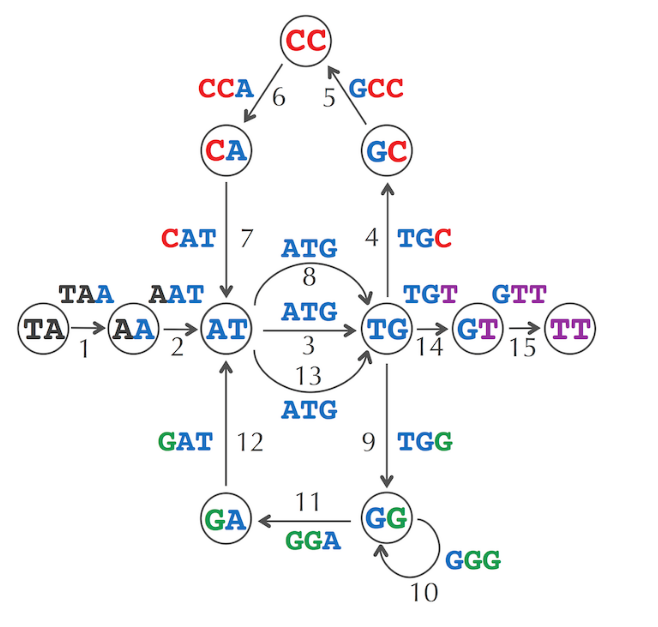

We now have an alternative way of solving the String Reconstruction Problem that amounts to finding an Eulerian path in the de Bruijn graph. But wait — to construct the de Bruijn graph of a genome, we glued together nodes of its path graph. However, constructing this graph requires us to know the correct ordering of the $k$-mers in the genome. Hence, we must find a way to construct the de Bruijn graph from the $k$-mer composition of the genome.

We represent the $3$-mer composition of `TAATGCCATGGGATGTT` as a **composition graph**, in which each 3-mer is assigned to a directed edge, with its prefix labeling the first node of the edge and its suffix labeling the second node of the edge. However, the edges of this graph are isolated, meaning that no two edges share a node.

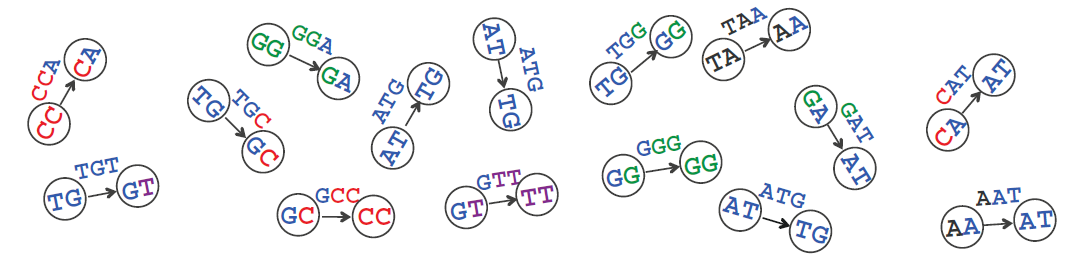

By gluing *some* nodes with the same label in the composition graph, we obtain the path graph. By gluing *all* nodes with the same label in the composition graph, we obtain the de Bruijn graph.

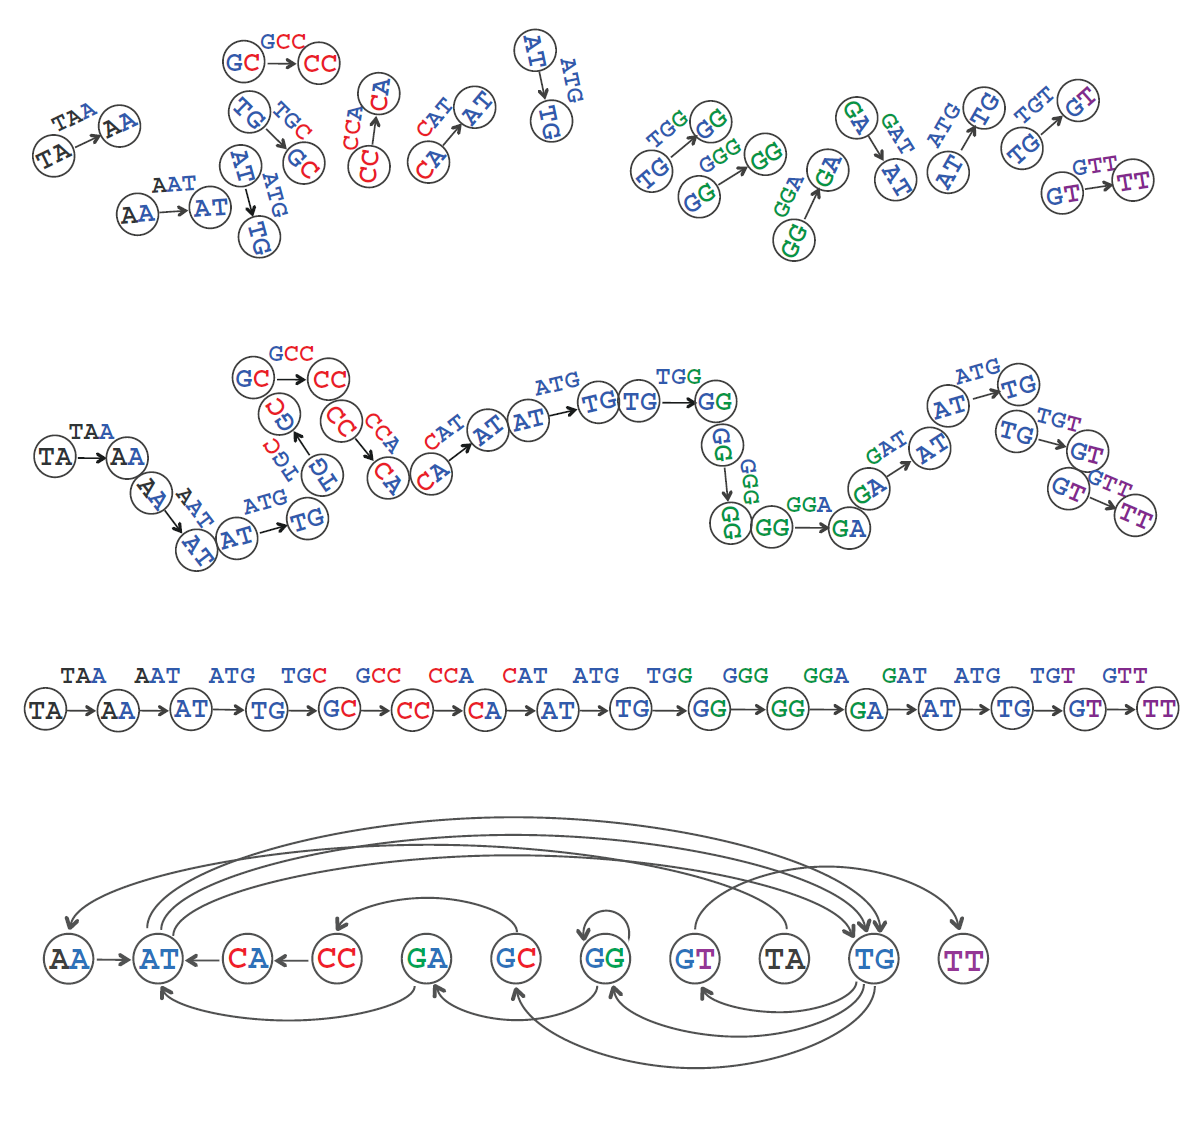

There is another useful way to construct de Bruijn graphs without gluing. Given a collection of $k$-mers $\text{Patterns}$, the nodes of $\text{DeBruijn}_k(\text{Patterns})$ are simply all unique $(k-1)$-mers occurring as a prefix or suffix of $k$-mers in $\text{Patterns}$. For every $k$-mer in $\text{Patterns}$, we connect its prefix node to its suffix node by a directed edge in order to produce $\text{DeBruijn}_k(\text{Patterns})$.

In [ ]:
def de_bruijn_from_composition(patterns):

  k = len(patterns[0])
  nodes = []
  for pattern in patterns:
    prefix = pattern[:k-1]
    if prefix not in nodes:
      nodes.append(prefix)
    suffix = pattern[-k+1:]
    if suffix not in nodes:
      nodes.append(suffix)

  de_bruijn = {node:[] for node in nodes}

  for pattern in patterns:
    prefix = pattern[:k-1]
    suffix = pattern[-k+1:]
    de_bruijn[prefix].append(suffix)

  for node in list(de_bruijn.keys()):
    if len(de_bruijn[node]) == 0:
      del de_bruijn[node]

  return de_bruijn

In [ ]:
de_bruijn_from_composition(composition("TAATGCCATGGGATGTT",3))

{'AA': ['AT'],
 'AT': ['TG', 'TG', 'TG'],
 'TG': ['GC', 'GG', 'GT'],
 'CA': ['AT'],
 'CC': ['CA'],
 'GA': ['AT'],
 'GC': ['CC'],
 'GG': ['GA', 'GG'],
 'GT': ['TT'],
 'TA': ['AA']}

We now have two ways of solving the String Reconstruction Problem. We can either find a Hamiltonian path in the overlap graph or find an Eulerian path in the de Bruijn graph. However, we have only changed a single word in the statements of the Hamiltonian and Eulerian Path Problems, from finding a path visiting every *node* exactly once to finding a path visiting every *edge* exactly once.

In the case of real assembly problems, both graphs will have millions of nodes, and so all that matters is finding an efficient algorithm for reconstructing the genome. If we can find an efficient algorithm for the Hamiltonian Path Problem, but not for the Eulerian path Problem, then we should select the overlap graph even though it looks more complex.

# The Seven Bridges of Königsberg

In 1735, the Prussian city of Königsberg, which today is Kaliningrad, Russia, comprised both banks of the Pregel River as well as two river
islands; seven bridges connected these four different parts of the city. Königsberg's residents enjoyed taking walks, and they asked a simple
question: Is it possible to set out from my house, cross each bridge exactly once, and return home? Their question became known as the **Bridges of Königsberg Problem**.

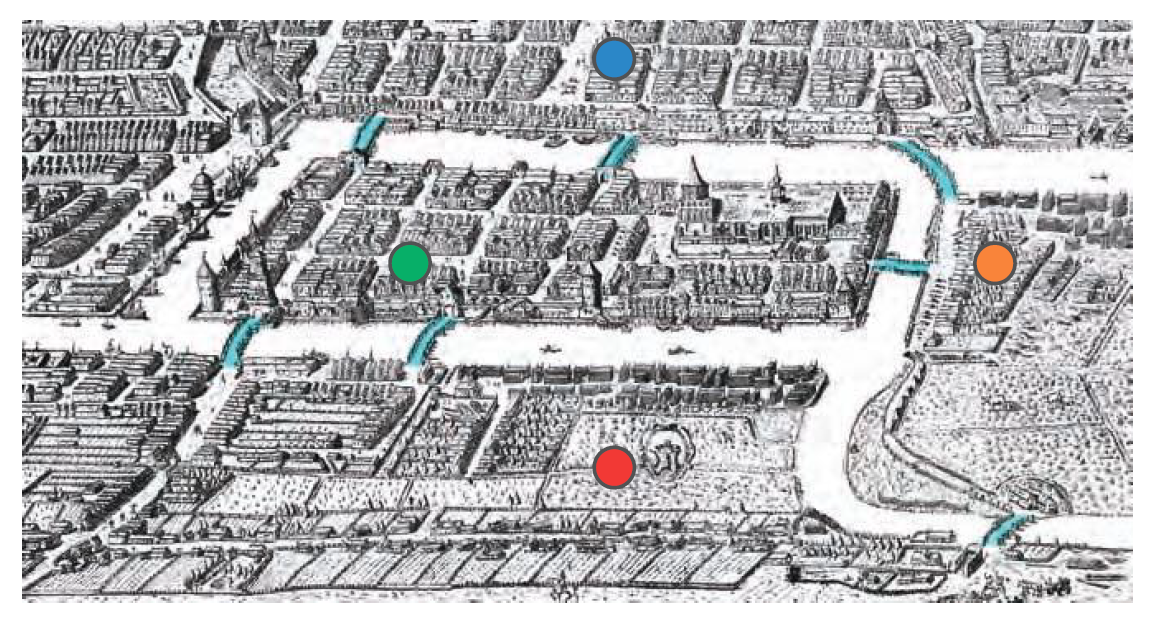

To solve the problem, the great mathematician Leonhard Euler drew a graph whose nodes represented the four sectors of the city, and its edges represented the seven bridges connecting different sectors. Note that the edges are undirected, meaning that they can be traversed in either direction.

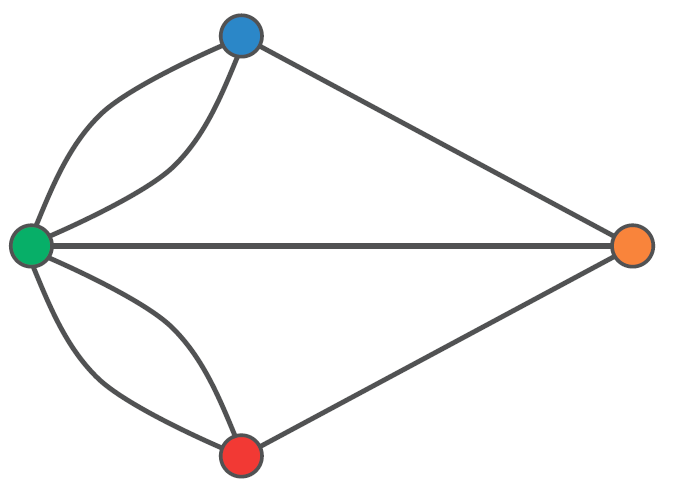

We have already defined an Eulerian path as a path in a graph traversing each edge of a graph exactly once. A **cycle** that traverses each edge of a graph exactly once is called an **Eulerian cycle**, and we say that a graph containing such a cycle is an **Eulerian graph**.

Euler solved the Bridges of Königsberg Problem, showing that no walk can cross each bridge exactly once (i.e., the graph is not Eulerian). To do so, he proved a theorem dictating when a graph will have an Eulerian cycle.

His theorem immediately implies an efficient algorithm for constructing an Eulerian cycle in any Eulerian graph, even one having millions of edges. Furthermore, this algorithm can easily be extended into an algorithm constructing an Eulerian path (in a graph having such a path), which will allow us to solve the String Reconstruction Problem by using the de Bruijn graph. On the other hand, it turns out that no one has ever been able to find an efficient algorithm solving the Hamiltonian Path Problem.

# Euler's Theorem

Euler worked with undirected graphs, but we will consider an analogue of his algorithm for directed graphs so that his method will apply to genome assembly.

Consider an ant walking along the edges of an Eulerian cycle. Every time it enters a node of this graph by an edge, it is able to leave this
node by another, unused edge. Thus, in order for a graph to be Eulerian, the number of incoming edges at any node must be equal to the number of outgoing edges at that node.

We define the **indegree** and **outdegree** of a node $v$ (denoted $\text{In}(v)$ and $\text{Out}(v)$, respectively) as the number of edges leading into and out of $v$. A node $v$ is a **balanced node** if $\text{In}(v)=\text{Out}(v)$, and a graph is a **balanced graph** if all its nodes are balanced. Because the ant must always be able to leave a node by an unused edge, any Eulerian graph must be balanced.

Consider the following example of a balanced (left) and an unbalanced (right) graph:

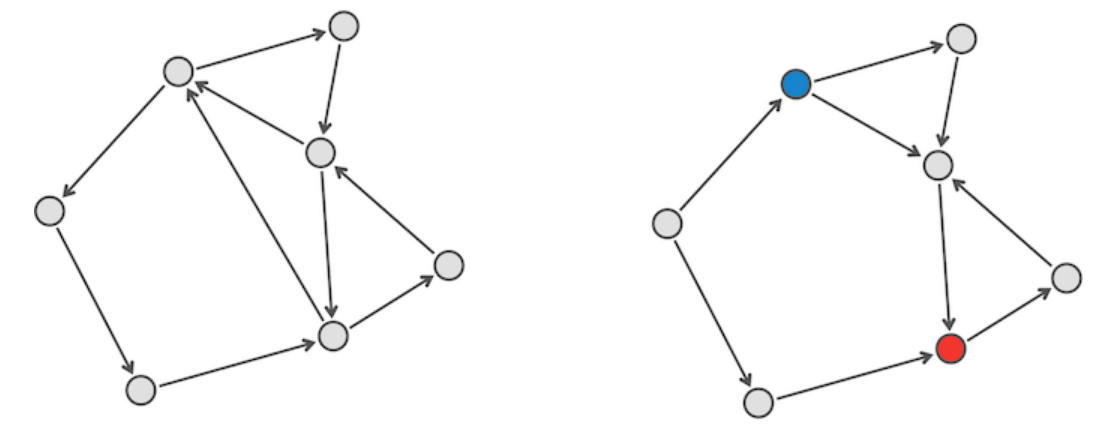

A directed graph is **disconnected** if some nodes cannot be reached from other nodes. In any disconnected graph, it is impossible to find an Eulerian cycle. In contrast, we say that a directed graph is
**strongly connected** if it is possible to reach any node from every other node.

The following example is a balanced, disconnected graph:

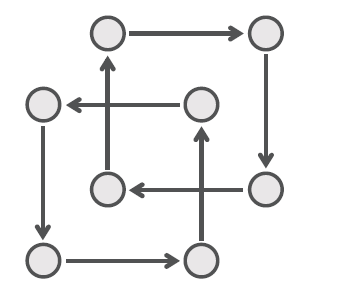

An Eulerian graph must be both balanced and strongly connected. **Euler's Theorem** states that these two conditions are sufficient to guarantee that an arbitrary graph is Eulerian. As a result, it implies that we can determine whether a graph is Eulerian without ever having to draw any cycles.

**A constructive proof for Euler's Theorem**

---

Let $\text{Graph}$ be an arbitrary balanced and strongly connected directed graph. To prove that $\text{Graph}$ has an Eulerian cycle, place the ant at any node $v_0$ of $\text{Graph}$ (the green node in the figure below), and let it randomly walk through the graph under the condition
that it cannot traverse the same edge twice.

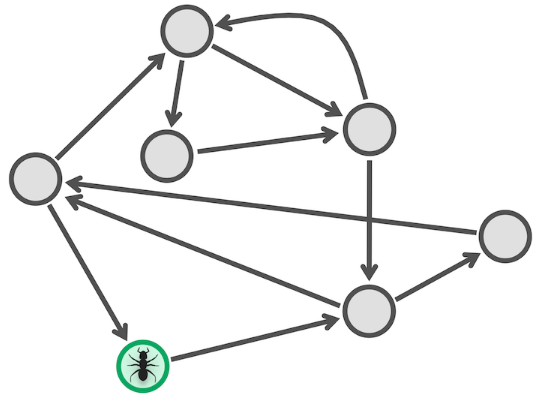

Odds are that the ant will "get stuck" somewhere before it can complete an Eulerian cycle, meaning that it reaches a node and finds no unused edges leaving that node.

It turns out that the only node where it can get stuck is the starting node $v_0$! The reason why is that $\text{Graph}$ is balanced: if the ant walks into any node other than $v_0$ (through an incoming edge), then it will always be able to escape via an unused outgoing edge. The only exception to this rule is the starting node $v_0$, since the ant has used up one of the outgoing edges of $v_0$ in its first move. Now, because it has returned to $v_0$, the result of the walk is a cycle, which we call $\text{Cycle}_0$.

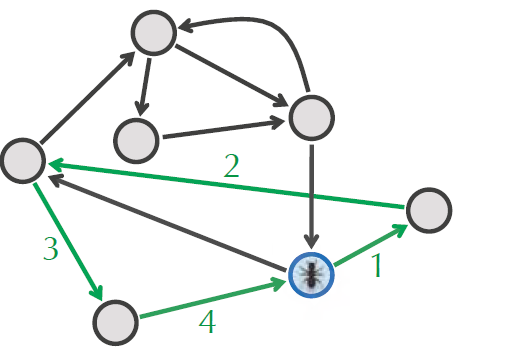

If $\text{Cycle}_0$ is Eulerian, then we are finished. Otherwise, because $\text{Graph}$ is strongly connected, some node on $\text{Cycle}_0$ must have unused edges entering it and leaving it. Naming this node $v_1$, we ask the ant to start at $v_1$ instead of $v_0$ and traverse $\text{Cycle}_0$ (thus returning to $v_1$).

Now, there are unused edges starting at this node, and so he can continue walking from $v_1$, using a new edge each time. The same argument as the one that we used before implies that the ant must eventually get stuck at $v_1$. The result of the ant's walk is a new cycle, $\text{Cycle}_1$, which is larger than $\text{Cycle}_0$.

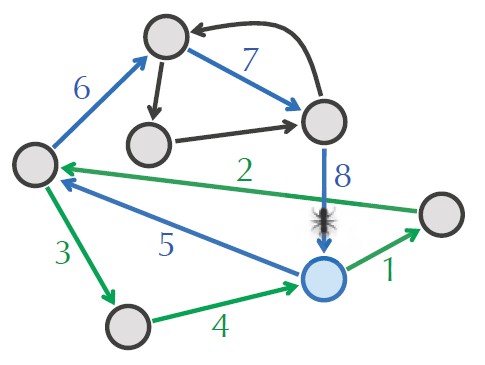

If $\text{Cycle}_1$ is an Eulerian cycle, then the ant has completed its job. Otherwise, we select a node $v_2$ in $\text{Cycle}_1$ that has unused edges entering it and leaving it (the red node in the figure below). Starting at $v_2$, we ask the ant to traverse $\text{Cycle}_1$, returning to $v_2$. Afterwards, it will randomly walk until it gets stuck at $v_2$,
creating an even larger cycle that we name $\text{Cycle}_2$.

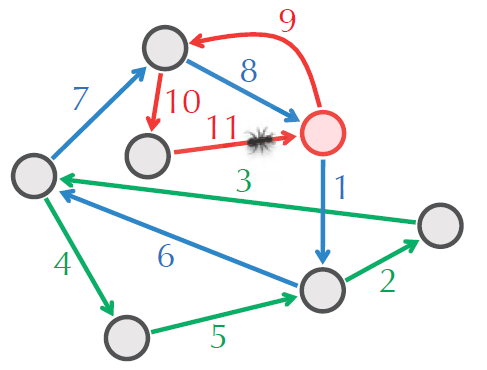

$\text{Cycle}_2$ happens to be Eulerian, although this is certainly not
the case for an arbitrary graph. In general, the ant generates larger and larger cycles at each iteration, and so we are guaranteed that sooner or later some $\text{Cycle}_m$ will traverse all the edges in $\text{Graph}$. This cycle must be Eulerian, and so we are finished.

# From Euler's Theorem to an Algorithm for Finding Eulerian Cycles

The algorithm to find an Eulerian cycle requires us to track a fictional ant's movements until it inevitably produces an Eulerian cycle in a balanced and strongly connected graph.

In [ ]:
import random

In [ ]:
def eulerian_cycle(graph,req_start=None):

  nodes = list(graph.keys())
  edges = len([y for x in list(graph.values()) for y in x])

  start_node = random.choice(nodes)
  next_node = random.choice(graph[start_node])
  graph[start_node].remove(next_node)
  nodes_visited = [start_node,next_node]
  start_node = next_node
  while nodes_visited[-1] != nodes_visited[0] or graph[nodes_visited[0]] != []:
    next_node = random.choice(graph[start_node])
    graph[start_node].remove(next_node)
    nodes_visited.append(next_node)
    start_node = next_node

  while len(nodes_visited) != edges + 1:
      new_start = nodes_visited.index(random.choice([node for node in nodes_visited if graph[node]!=[]]))
      nodes_visited = nodes_visited[new_start:] + nodes_visited[1:new_start+1]
      start_node = nodes_visited[-1]
      next_node = random.choice(graph[start_node])
      graph[start_node].remove(next_node)
      nodes_visited.append(next_node)
      start_node = next_node

      while nodes_visited[-1] != nodes_visited[0] or graph[nodes_visited[0]] != []:
        next_node = random.choice(graph[start_node])
        graph[start_node].remove(next_node)
        nodes_visited.append(next_node)
        start_node = next_node

  if req_start != None:
    req_start = nodes_visited.index(req_start)
    nodes_visited = nodes_visited[req_start:] + nodes_visited[1:req_start+1]

  return nodes_visited

In [ ]:
example_graph = {0:[1],1:[2,6],2:[6],3:[1,4],4:[3,5],5:[3],6:[0,4]}
eulerian_cycle(example_graph)

[4, 5, 3, 4, 3, 1, 2, 6, 0, 1, 6, 4]

We can now check if a directed graph has an Eulerian cycle, but what about an Eulerian path? Consider the de Bruijn graph below, which we already know
has an Eulerian path. But, it does not have an Eulerian cycle because nodes `TA` and `TT` are not balanced. However, we can transform this Eulerian path into an Eulerian cycle by adding a single edge connecting `TT` to `TA`.

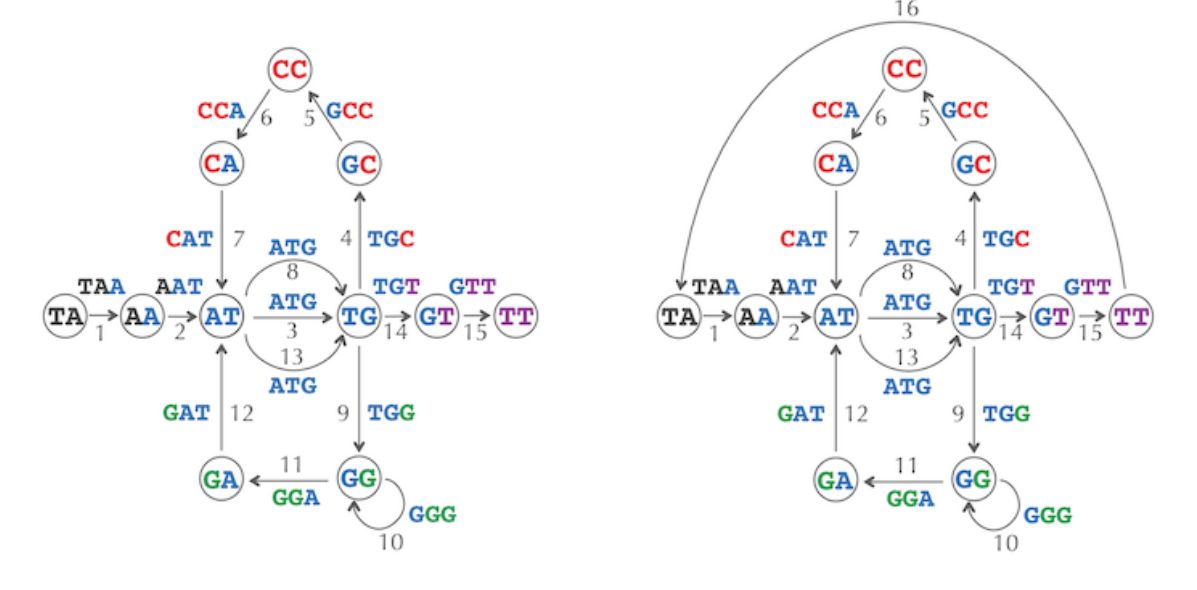

More generally, consider a graph that does not have an Eulerian cycle but does have an Eulerian path. If an Eulerian path in this graph connects a node $v$ to a different node $w$, then the graph is **nearly balanced**, meaning that all its nodes except $v$ and $w$ are balanced. In this case, adding an extra edge from $w$ to $v$ transforms the Eulerian path into an Eulerian cycle. Thus, a nearly balanced graph has an Eulerian path if and only if adding an edge between its unbalanced nodes makes the graph balanced and strongly connected.

In [ ]:
def eulerian_path(graph):

  nodes = list(graph.keys())
  in_degree = {node:0 for node in nodes}
  out_degree = {node:0 for node in nodes}

  for node in nodes:
    edges = graph[node]
    out_degree[node] = len(edges)
    for edge in edges:
      if edge in list(in_degree.keys()):
        in_degree[edge] += 1
      else:
        in_degree[edge] = 1

  for node in list(in_degree.keys()):
    if node not in list(out_degree.keys()):
      out_degree[node] = 0

  node1 = None
  node2 = None

  for node in list(in_degree.keys()):
    if in_degree[node] > out_degree[node]:
      node1 = node
    elif in_degree[node] < out_degree[node]:
      node2 = node

  graph[node1] = [node2]

  return eulerian_cycle(graph,node2)[:-1]

In [ ]:
example_graph = {0:[2],1:[3],2:[1],3:[0,4],6:[3,7],7:[8],8:[9],9:[6]}
eulerian_path(example_graph)

[6, 7, 8, 9, 6, 3, 0, 2, 1, 3, 4]

We now have a method to assemble a genome, since the String Reconstruction
Problem reduces to finding an Eulerian path in the de Bruijn graph generated from reads.

In [ ]:
def assemble_genome(composition):

  de_bruijn_graph = de_bruijn_from_composition(composition)
  path_graph = eulerian_path(de_bruijn_graph)
  genome = genome_from_genome_path(path_graph)

  return genome

In [ ]:
assemble_genome(['AAT',
 'ATG',
 'ATG',
 'ATG',
 'CAT',
 'CCA',
 'GAT',
 'GCC',
 'GGA',
 'GGG',
 'GTT',
 'TAA',
 'TGC',
 'TGG',
 'TGT'])

'TAATGGGATGCCATGTT'

**Constructing universal strings**

---

Now that we know how to use the de Bruijn graph to solve the String Reconstruction Problem, we can also construct a $k$-universal string for any value of $k$. A point to note is that de Bruijn was interested in constructing **$k$-universal circular strings**. For example, $00011101$ is a $3$-universal circular string, as it contains each of the eight binary $3$-mers exactly once.



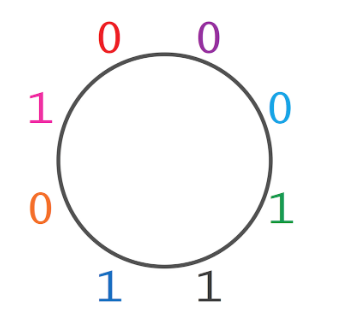

Like its analogue for linear strings, the $k$-Universal Circular String Problem is just a specific case of a more general problem, which requires us to reconstruct a circular string given its $k$-mer composition. This problem models the assembly of a circular genome containing a single chromosome, like the genomes of most bacteria.

We know that we can reconstruct a circular string from its $k$-mer composition by finding an Eulerian cycle in the de Bruijn graph constructed from these $k$-mers. Therefore, we can construct a
$k$-universal circular binary string by finding an Eulerian cycle in the de Bruijn graph constructed from the collection of all binary $k$-mers

In [ ]:
def immediate_neighbors(pattern):

  neighborhood = [pattern]

  for i in range(len(pattern)):

    prefix = pattern[:i]
    symbol = pattern[i]
    suffix = pattern[i+1:]

    alternates = list({"0","1"} - {symbol})

    for alternate in alternates:
      neighbor = prefix + alternate + suffix
      neighborhood.append(neighbor)

  return neighborhood

In [ ]:
def neighbors(pattern,d):

  neighborhood = [pattern]

  for i in range(d):
    current_neighborhood = neighborhood.copy()
    for neighbor in current_neighborhood:
      for immediate_neighbor in immediate_neighbors(neighbor):
        if immediate_neighbor not in neighborhood:
          neighborhood.append(immediate_neighbor)

  return neighborhood

In [ ]:
def generate_binary_k_mers(k):

  return neighbors("0"*k,k)

In [ ]:
def find_universal_circular_string(k):

  k_mers = generate_binary_k_mers(k)
  graph = de_bruijn_from_composition(k_mers)
  path = eulerian_cycle(graph)[:-1]
  string = ""
  for node in path:
    string += node[-1]

  return string

In [ ]:
find_universal_circular_string(3)

'10100011'

# Assembling Genomes from Read-Pairs

We have already mentioned that assembling reads sampled from a randomly generated text is a trivial problem, since random strings are not expected to have long repeats. As soon as read length exceeds the length of all repeats in a genome (provided the reads have no errors), the de Bruijn graph turns into a path. However, despite many attempts, biologists have not yet figured out how to generate long and accurate reads. The most accurate sequencing technologies available today generate reads that are only about 300 nucleotides long, which is too short to span most repeats,
even in short bacterial genomes.

We also saw earlier that the string `TAATGCCATGGGATGTT` cannot be uniquely reconstructed from its $3$-mer composition since another string (`TAATGGGATGCCATGTT`) has the same $3$-mer composition. Increasing read length would help identify the correct assembly, but since increasing
read length presents a difficult experimental problem.

Thus, biologists have suggested an indirect way of increasing read length by generating **read-pairs**, which are pairs of reads separated by a fixed distance $d$ in the genome. We can think about a read-pair as a long “gapped” read of length $k + d + k$ whose first and last $k$-mers are
known but whose middle segment of length $d$ is unknown.


The following is an example of read-pairs sampled from `TAATGCCATGGGATGTT` and formed by reads of length $3$ separated by a gap of length $1$:


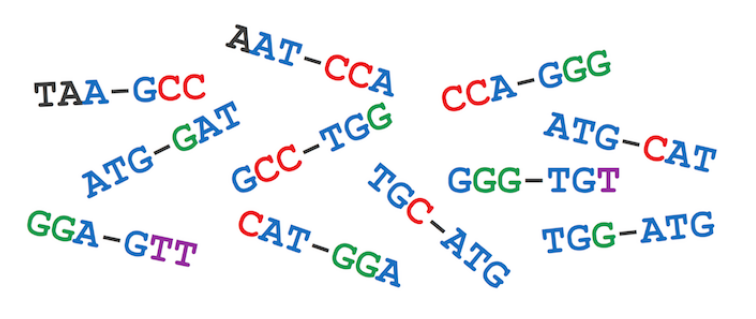

Read-pairs contain more information than $k$-mers alone, and so we can use them to improve our assemblies. If we can infer the nucleotides in the middle segment of a read-pair, we can immediately increase the read length from just $k$ to $2 \cdot k + d$.

Let $\text{Reads}$ be the collection of all $2N$ $k$-mer reads taken from $N$ read-pairs. Note that a read-pair formed by $k$-mer reads $\text{Read}_1$ and $\text{Read}_2$ corresponds to two edges in the de Bruijn graph $\text{DeBruijn}_k(\text{Reads})$. Since these reads are separated by distance $d$ in the genome, there must be a path of length $(2 \cdot k + d) - k + 1 = k + d + 1$ in $\text{DeBruijn}_k(\text{Reads})$ connecting the node at the beginning of the edge corresponding to $\text{Read}_1$ with the node at the end of the edge corresponding to $\text{Read}_2$.

For example, consider the highlighted path of length $3+1+1=5$ for the gapped read `AAT-CCA`, which spells out `AATGCCA`:

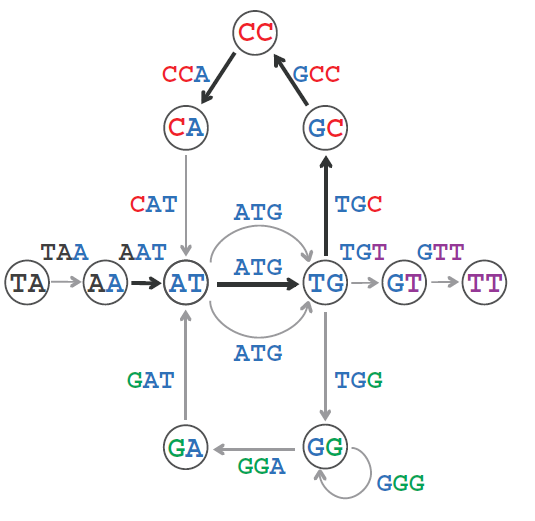

Thus, from two short reads of length $k$, we have generated a **long virtual read** of length $2 \cdot k + d$, achieving computationally what
researchers still cannot achieve experimentally! After preprocessing the de Bruijn graph to produce long virtual reads, we can simply construct the de Bruijn graph from these long reads and use it for genome assembly.

Although the idea of transforming read-pairs into long virtual reads is used in many assembly programs, we have made an optimistic assumption: *“If there is only one path of length $k + d + 1$ connecting these nodes, or if all such paths spell out the same string . . . ”*.

In practice, this assumption limits the application of the long virtual read approach to assembling read-pairs because highly repetitive genomic regions often contain multiple paths of the same length between two edges, and these paths often spell different strings. For example, consider the two highlighted paths below that connect `AAT` to `ACA` in `AATCTGACATATGG`, have the same length ($=7$), but spell out different virtual reads:

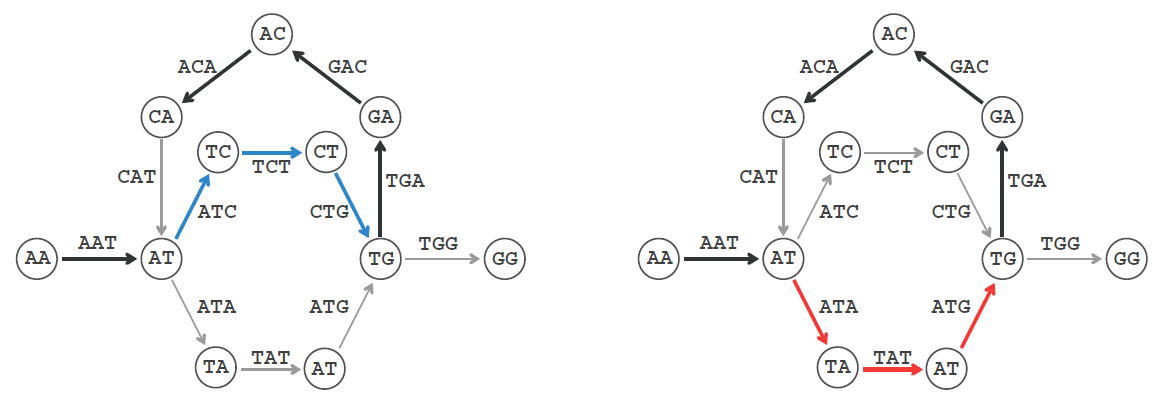

For this reason we cannot reliably transform a read-pair into a
long read. Instead, we will describe an alternative approach to analyzing read-pairs.

Given a string $\text{Text}$, a ($k, d$)-mer is a pair of $k$-mers in $\text{Text}$ separated by distance $d$. We use the notation ($\text{Pattern}_1 | \text{Pattern}_2$) to refer to a ($k, d$)-mer whose $k$-mers are $\text{Pattern}_1$ and $\text{Pattern}_2$. For example, (`ATG` | `GGG`) is a ($3, 4$)-mer in `TAATGCCATGGGATGTT`.

The **($k, d$)-mer composition** of $\text{Text}$, denoted $\text{PairedComposition}_{k, d}(\text{Text})$, is the collection
of all ($k, d$)-mers in $\text{Text}$ (including repeated ($k, d$)-mers). For example, here is $\text{PairedComposition}_{3, 1}$(`TAATGCCATGGGATGTT`):

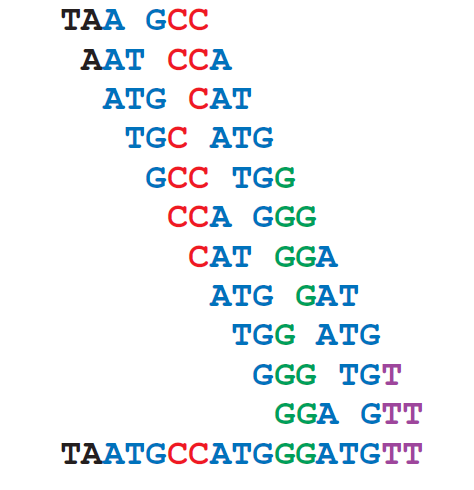

Since the order of ($k, d$)-mers in the paired composition is unknown, we list them according to the lexicographic order of the $2k$-mers formed by their concatenated $k$-mers:

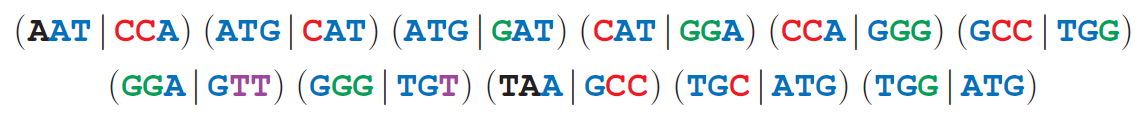

Note that whereas there are repeated $3$-mers in the $3$-mer composition of `TAATGCCATGGGATGTT`, there are no repeated ($3, 1$)-mers in its paired composition. Furthermore, although `TAATGCCATGGGATGTT` and `TAAATGCCATGGGATGTT` have the same $3$-mer composition, they have different ($3, 1$)-mer compositions. Thus, if we can generate the ($3, 1$)-mer composition of these strings, then we will be able to distinguish between them.

In [ ]:
def paired_composition(genome, k, d):

  paired_composition = []

  for i in range(len(genome) - (2*k + d) + 1):
    string = genome[i:i+(2*k)+d]
    paired_composition.append(string[:k]+string[-k:])

  paired_composition.sort()

  sorted_paired_composition = []

  for string in paired_composition:
    sorted_paired_composition.append((string[:k],string[-k:]))

  return sorted_paired_composition

In [ ]:
paired_composition("TAATGCCATGGGATGTT",3,1)

[('AAT', 'CCA'),
 ('ATG', 'CAT'),
 ('ATG', 'GAT'),
 ('CAT', 'GGA'),
 ('CCA', 'GGG'),
 ('GCC', 'TGG'),
 ('GGA', 'GTT'),
 ('GGG', 'TGT'),
 ('TAA', 'GCC'),
 ('TGC', 'ATG'),
 ('TGG', 'ATG')]

**Paired de Bruijn graphs**

---

Given a ($k, d$)-mer ($a_1, ..., a_k$ | $b_1, ..., b_k$), we define its prefix as ($a_1, ..., a_{k-1}$ | $b_1, ..., b_{k-1}$) and suffix as ($a_2, ..., a_k$ | $b_2, ..., b_k$). For example the prefix of (`GAC` | `TCA`) is (`GA` | `TC`), while its suffix is (`AC` | `CA`).

Note that for consecutive ($k, d$)-mers appearing in $\text{Text}$, the suffix of the first ($k, d$)-mer is equal to the prefix of the second ($k, d$)-mer. For example, for the consecutive ($k, d$)-mers (`TAA` | `GCC`) and (`AAT` | `CCA`) in `TAATGCCATGGGATGTT`, the suffix of (`TAA` | `GCC`) and the prefix of (`AAT` | `CCA`) are the same - (`AA` | `CC`).

Given a string $\text{Text}$, we construct a graph $\text{PathGraph}_{k, d}(\text{Text})$ that represents a path formed by $|\text{Text}|-(2 \cdot k+d)-1$ edges corresponding to all ($k, d$)-mers in $\text{Text}$.
We label edges in this path by ($k, d$)-mers and label the starting and ending nodes of an edge by its prefix and suffix, respectively.

Consider $\text{PathGraph}_{3, 1}$(`TAATGCCATGGGATGTT`):



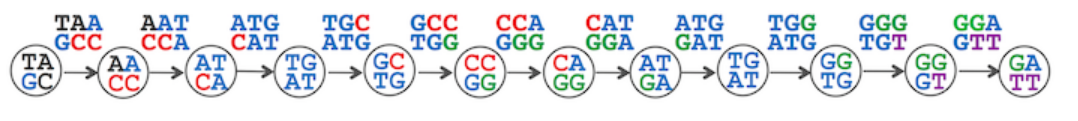

The **paired de Bruijn graph**, denoted $\text{DeBruijn}_{k, d}(\text{Text})$, is formed by gluing identically labeled nodes in $\text{PathGraph}_{k, d}(\text{Text})$.

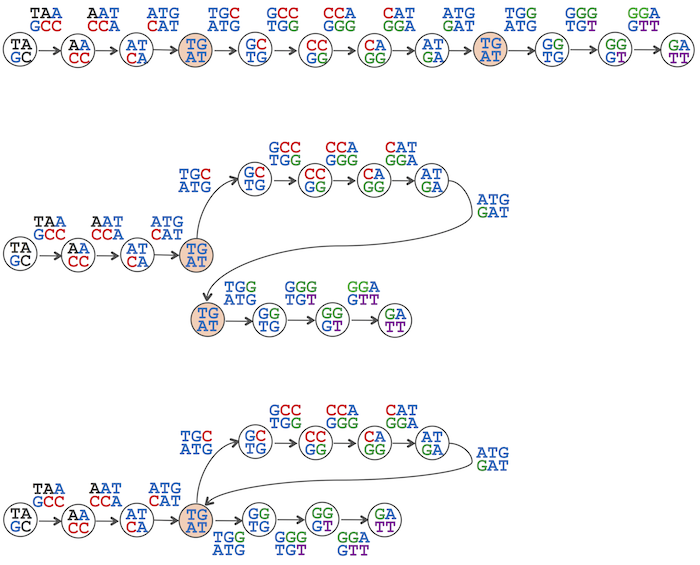

To obtain this paired de Bruijn graph, we glue together identical nodes in the paired composition graph that is formed by isolated edges corresponding to the ($k,d$)-mers:

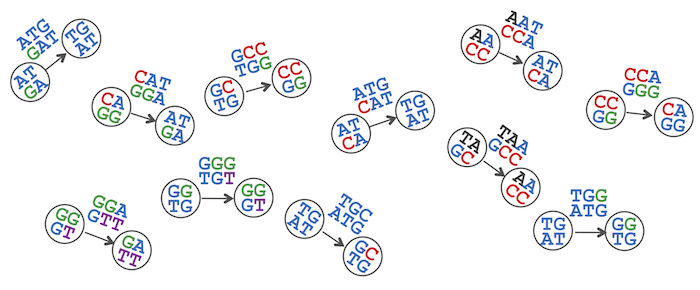

In [ ]:
def paired_de_bruijn(paired_composition):

  k = len(paired_composition[0][0])

  nodes = []
  for string1,string2 in paired_composition:
    prefix = (string1[:k-1],string2[:k-1])
    if prefix not in nodes:
      nodes.append(prefix)
    suffix = (string1[-k+1:],string2[-k+1:])
    if suffix not in nodes:
      nodes.append(suffix)

  paired_de_bruijn = {node:[] for node in nodes}

  for string1,string2 in paired_composition:
    prefix = (string1[:k-1],string2[:k-1])
    suffix = (string1[-k+1:],string2[-k+1:])
    paired_de_bruijn[prefix].append(suffix)

  for node in list(paired_de_bruijn.keys()):
    if len(paired_de_bruijn[node]) == 0:
      del paired_de_bruijn[node]

  return paired_de_bruijn

In [ ]:
test_comp = [('AAT', 'CCA'),
 ('ATG', 'CAT'),
 ('ATG', 'GAT'),
 ('CAT', 'GGA'),
 ('CCA', 'GGG'),
 ('GCC', 'TGG'),
 ('GGA', 'GTT'),
 ('GGG', 'TGT'),
 ('TAA', 'GCC'),
 ('TGC', 'ATG'),
 ('TGG', 'ATG')]

In [ ]:
paired_de_bruijn(test_comp)

{('AA', 'CC'): [('AT', 'CA')],
 ('AT', 'CA'): [('TG', 'AT')],
 ('TG', 'AT'): [('GC', 'TG'), ('GG', 'TG')],
 ('AT', 'GA'): [('TG', 'AT')],
 ('CA', 'GG'): [('AT', 'GA')],
 ('CC', 'GG'): [('CA', 'GG')],
 ('GC', 'TG'): [('CC', 'GG')],
 ('GG', 'GT'): [('GA', 'TT')],
 ('GG', 'TG'): [('GG', 'GT')],
 ('TA', 'GC'): [('AA', 'CC')]}

The genome can be reconstructed by following an Eulerian path in this de Bruijn graph. However, it is important to note that not every Eulerian path
in the paired de Bruijn graph constructed from a ($k, d$)-mer composition spells out the true genome.

For example, consider the paired de Bruijn graph shown below. It has two Eulerian paths. One of them is `AG-AG → GC-GC → CA-CT → AG-TG → GC-GC → CT-CT → TG-TG → GC-GC → CT-CA`, while the other is `AG-AG → GC-GC → CT-CT → TG-TG → GC-GC → CA-CT → AG-TG → GC-GC → CT-CA`. The first one successfully reconstructs a genome, while the second one does not due to internal inconsistencies.

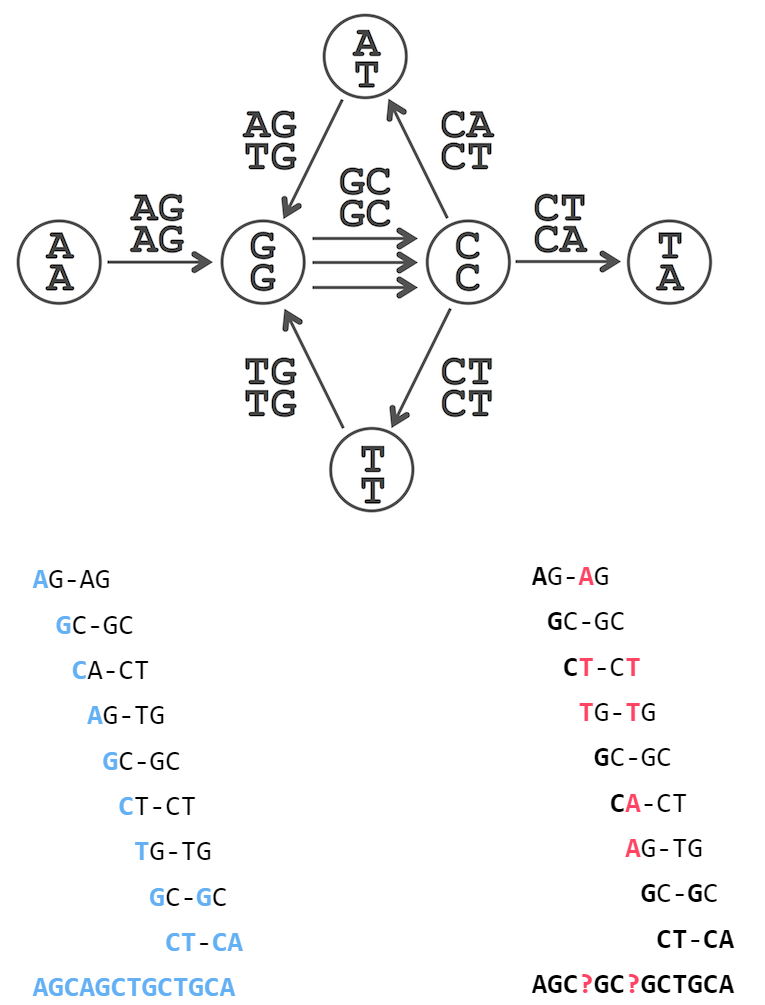

Thus, we should find all Eulerian paths (by finding all Eulerian cycles) in the paired de Bruijn graph and attempt to reconstruct the genome from them one at a time.

The inherent difficulty in generating all Eulerian cycles in a graph is keeping track of potentially many different alternatives at any given node. On the opposite end of the spectrum, a **simple directed graph**, a connected graph in which each node has indegree and outdegree equal to $1$, offers a trivial case, since there is only one Eulerian cycle.

Our idea, then, is to transform a single labeled directed graph containing
$n \geq 1$ Eulerian cycles to $n$ different simple directed graphs, each containing a single Eulerian cycle. This transformation has the property that it is easily invertible, i.e., that given the unique Eulerian cycle in one of the simple directed graphs, we can easily reconstruct the original Eulerian cycle.

Given a node $v$ with indegree greater than $1$ with an incoming edge $(u,v)$ and outgoing edge $(v,w)$, we construct a simpler **$(u,v,w)$-bypass graph** in which we remove the edges $(u,v)$ and $(v,w)$, and add a new node $x$ along with the edges $(u,x)$ and $(x,w)$. These two new edges inherit the labels of $(u,v)$ and $(v,w)$ respectively.



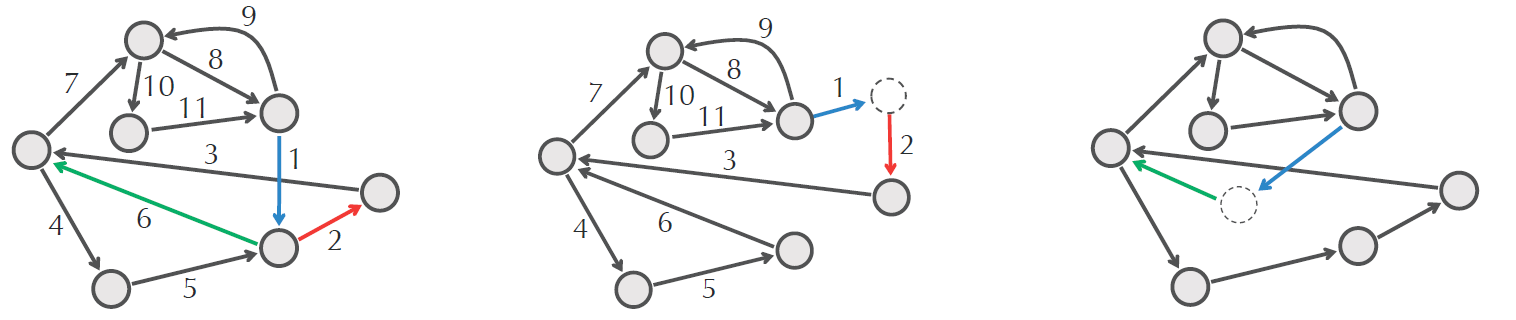

Any Eulerian cycle passing through $(u,v)$ and $(v,w)$ in the original graph will pass through $(u,x)$ and $(x,w)$ in the bypass graph. In general, given an incoming edge $(u, v)$ into $v$ along with $k$ outgoing edges $(v,w_1), . . . , (v,w_k)$ from $v$, we can construct $k$ different bypass graphs, each with a different Eulerian cycle.

Our idea is to iteratively construct every possible bypass graph for
the original graph until we obtain a large family of simple directed graphs; each one of these graphs will correspond to a distinct Eulerian cycle in the original graph.

In [ ]:
def node_degrees(graph):

  nodes = list(graph.keys())
  in_degree = {node:0 for node in nodes}
  out_degree = {node:0 for node in nodes}

  for node in nodes:
    edges = graph[node]
    out_degree[node] = len(edges)
    for edge in edges:
      if edge in list(in_degree.keys()):
        in_degree[edge] += 1
      else:
        in_degree[edge] = 1

  for node in list(in_degree.keys()):
    if node not in list(out_degree.keys()):
      out_degree[node] = 0

  return in_degree, out_degree

In [ ]:
def node_edges(graph, v):

  incoming = []

  for u in list(graph.keys()):
    if v in graph[u]:
      incoming.append(u)

  outgoing = graph[v]

  return incoming, outgoing

In [ ]:
def check_simple(graph):

  in_degree, out_degree = node_degrees(graph)

  for node in list(in_degree.keys()):
    if in_degree[node] != 1 or out_degree[node] != 1:
      return False

  return True